# <center>Notebook - Exploring Chicago Neighborhood Venues and Predicting Economic Hardship</center>

This notebook will be mainly used for the capstone project. This was written for the first part of the project.

Begin by installing and importing any required packages

In [290]:
# Importing required libraries
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim
import folium
import requests
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt

In [7]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [7]:
# Install all required modules if required
# !pip install BeautifulSoup4
!pip install geocoder
# !pip install geopy
# !pip install folium
# !pip install -U scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Introduction and Business Proposal

Studies have shown that many of Chicago's neighborhoods and suburbs are stratified by income. As someone who has lived in Chicago most of their life, I have observed this myself. One moment you may be walking down a neighborhood full of abandoned houses and people struggling to make ends meet, and a few neighborhoods over you may have people living in mansions. To better study the economic difficulties that different neighborhoods/communities across Chicago face, the University of Illinois at Chicago (UIC) developed the "hardship index". The economic hardship score is an average of six standardized variables: Unemployment, Education, per capita income level, poverty, crowded housing, dependency. <br><br>
Note, for the purposes of this study, neighborhoods and communities will be used interchangibly. While there are subtle differences between the two terms, they both divide groups of people into geographical sections. Furthermore, "communities" are the most clearly defined in Chicago <br><br>
As you can imagine, there are multiple factors that may affect a community's hardship index, such as its size, racial makeup, age, etc. However, here we will explore how the types of venues in a given neighborhood may affect the hardship score. The goal is for Chicago city officials and developers to be able to determine or predict how different venues may affect a neighborhoods' economy. Using this information, developers may also more effectively decide which venues should be constructed or demolished to benefit the community. 

## Data Description

First we will obtain the hardship index scores for all the neighborhoods in Chicago, from the City of Chicago's database. This is an integer score ranging from 0 - 100, where 100 is the highest hardship. <br>
We will also require geographical coordinate data for the neighborhoods in order to determine the nearby venues. We may obtain this data using geocoder and the neighborhood names. <br>
With the geographical data, we can then obtain a dataset of the nearby venues for each neighborhood using the Foursquare API. This will allow us to determine the popular venue categories for each neighborhood, and using this we can try to predict a given neighborhoods' hardship level

## Methodology - 

### Data Collection

**1. Chicago Community Harship and Socieoconomic Indicators Data**

First, we may collect the hardship data from the city of chicago's database

In [291]:
# First, let us obtain the data of the chicago hardship indices
city_chicago_url = 'https://data.cityofchicago.org/api/views/kn9c-c2s2/rows.csv?accessType=DOWNLOAD'
hardship_df = pd.read_csv(city_chicago_url)
hardship_df

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0
...,...,...,...,...,...,...,...,...,...
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16.0
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24.0
76,77.0,Edgewater,4.1,18.2,9.2,9.7,23.8,33385,19.0


**2. Collecting Geolocation Data**

Upon initial inspection of the dataframe, it was found that two of the communities had misspellings, Riverdale and Washington Heights. These misspellings would make it impossible for our geolocator to find the right coordinates. So, first **correct** the community names in the dataframe:

In [294]:
for ind in hardship_df.index:  
    curr_neighborhood = hardship_df["COMMUNITY AREA NAME"][ind]
    if curr_neighborhood == "Montclaire":
        hardship_df["COMMUNITY AREA NAME"][ind] = "Montclare"  # Correcting DB error on name
    if curr_neighborhood == "Washington Height":
        hardship_df["COMMUNITY AREA NAME"][ind] = "Washington Heights"  # Correcting DB error on name

Now we may obtain the geolocation data using Nominatim

In [295]:
# First, add empty Latitude and Longitude columns to df:
hardship_df["Latitude"] = ""
hardship_df["Longitude"] = ""

In [298]:
geolocator = Nominatim(user_agent="myChi_explorer")

# Loop through rows in df and assign latitude and longitude (known each row has unique postal code)
for ind in hardship_df.index:
    # initialize your variable to None
    latitude = None
    longitude = None
    
    curr_neighborhood = hardship_df["COMMUNITY AREA NAME"][ind]

    # loop until you get the coordinates
    while((latitude and longitude) is None):
      g = geolocator.geocode('{}, Chicago, IL'.format(curr_neighborhood))
      #lat_lng_coords = g.latlng
      if (g != None):  # Do not try to assign is result is none, this can happen for incorrect addresses
          latitude = g.latitude
          longitude = g.longitude

    hardship_df["Latitude"][ind] = latitude
    hardship_df["Longitude"][ind] = longitude

<ipython-input-298-5e3a6ed6432b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hardship_df["Latitude"][ind] = latitude
<ipython-input-298-5e3a6ed6432b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hardship_df["Longitude"][ind] = longitude


Then show our hardship dataframe, now with geolocation data

In [301]:
hardship_df

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Latitude,Longitude
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0,42.009037,-87.676849
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0,42.003548,-87.696243
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0,41.96663,-87.655546
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0,41.968512,-87.688653
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0,41.956107,-87.67916
...,...,...,...,...,...,...,...,...,...,...,...
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16.0,41.698243,-87.705408
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0,41.690312,-87.666716
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24.0,41.975164,-87.844242
76,77.0,Edgewater,4.1,18.2,9.2,9.7,23.8,33385,19.0,41.982814,-87.673951


### Data Preprocessing - 

**Chicago Socioeconomic Indicators Data Preprocessing**

We want to examine the 77 official community areas in Chicago. As such, the last row, with Community Name "CHICAGO" may be removed. It is unclear what this row refers to, and the Hardship score is Nan

In [302]:
hardship_df.drop(hardship_df[hardship_df['COMMUNITY AREA NAME'] == 'CHICAGO'].index, inplace = True)

Below is the new dataframe

In [303]:
hardship_df

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Latitude,Longitude
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0,42.009037,-87.676849
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0,42.003548,-87.696243
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0,41.96663,-87.655546
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0,41.968512,-87.688653
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0,41.956107,-87.67916
...,...,...,...,...,...,...,...,...,...,...,...
72,73.0,Washington Heights,1.1,16.9,20.8,13.7,42.6,19713,48.0,41.706543,-87.651863
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16.0,41.698243,-87.705408
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0,41.690312,-87.666716
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24.0,41.975164,-87.844242


Now, let us check if there are any other NaN values. These would cause problems for our model development

In [304]:
print("Nan values for hardship df- \n", hardship_df.isna().sum())

Nan values for hardship df- 
 Community Area Number                           0
COMMUNITY AREA NAME                             0
PERCENT OF HOUSING CROWDED                      0
PERCENT HOUSEHOLDS BELOW POVERTY                0
PERCENT AGED 16+ UNEMPLOYED                     0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    0
PERCENT AGED UNDER 18 OR OVER 64                0
PER CAPITA INCOME                               0
HARDSHIP INDEX                                  0
Latitude                                        0
Longitude                                       0
dtype: int64


As can be seen by the results above, there are no Nan values, so we may continue processing our data

**Feature Engineering**

For the purposes of this study, we are primarily interested in the hardship score for each community. As such, we may obtain a new dataframe with only the columns "COMMUNITY AREA NAME", "HARDSHIP INDEX", and "Latitude" and "Longitude". The other socioeconomic indicators may be examined in a later study. 

In [305]:
hardDf_eng = hardship_df[["COMMUNITY AREA NAME", "HARDSHIP INDEX", "Latitude", "Longitude"]]
hardDf_eng

,COMMUNITY AREA NAME,HARDSHIP INDEX,Latitude,Longitude
0,Rogers Park,39.0,42.009037,-87.676849
1,West Ridge,46.0,42.003548,-87.696243
2,Uptown,20.0,41.96663,-87.655546
3,Lincoln Square,17.0,41.968512,-87.688653
4,North Center,6.0,41.956107,-87.67916
...,...,...,...,...
72,Washington Heights,48.0,41.706543,-87.651863
73,Mount Greenwood,16.0,41.698243,-87.705408
74,Morgan Park,30.0,41.690312,-87.666716
75,O'Hare,24.0,41.975164,-87.844242


**FourSquare API Venue Data Collection**

First, define the FourSquare API credentials:

In [306]:
CLIENT_ID = 'FJICEMVPP0HJSSI4WPW41JQZHKG0QPAB4OGNRPCLC24NWFIU' # your Foursquare ID
CLIENT_SECRET = 'NB14VDI1V2OWJB0W3X1QEVIKUJWHHJ0BLO4GMVHYJT4IVEWC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Then, define the getNearbyVenues function below to explore nearby venues for all neighborhoods/communities

In [307]:
def getNearbyVenues(names, latitudes, longitudes, radius=650):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Check if there were no results for a given venue
        if len(results) == 0:
            print("--- NO RESULTS ---")
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['COMMUNITY AREA NAME', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then, get the nearby values and save them to the chicago_venues dataframe

In [308]:
# type your answer here
chicago_venues = getNearbyVenues(names=hardDf_eng['COMMUNITY AREA NAME'],
                                   latitudes=hardDf_eng['Latitude'],
                                   longitudes=hardDf_eng['Longitude']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
--- NO RESULTS ---
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


As can be seen from the output above with text "NO RESULTS", there was one neighborhood which returned no results - **Riverdale**. There are multiple ways to deal with no results or "Nan" results. To determine the best choice, research was one on Riverdale, and it turns out that it is primarily composed of  water reclamation plants, rail yards, land fills and industrial sites. In addition, a google maps search shows that there is not much else in the community. As such we will just use zero values for this community's venue results at a later point, indicating this community doesn't really have venues to offer. 

**Initial Data Visualization - Community Geolocation Data**

Before we further analyze the venue data, we may plot the communities on a map using folium. This will allow us to visually determine if the cooordinates look accurate and make initial insights

First, obtain the latitude and longitude coordinates of Chicago, IL so we have a point on where to center our folium map 

In [309]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chiIl_explorer")
location = geolocator.geocode(address)
latitudeC = location.latitude
longitudeC = location.longitude
print('The geograpical coordinates of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chicago are 41.8964706, -87.6357194.


Now, display folium map with neighborhoods marked using their latitude and longitude:

In [310]:
# create map of Toronto using latitude and longitude values
map_chicago = folium.Map(location=[latitudeC, longitudeC], zoom_start=10)

# add markers to map
for lat, lng, label in zip(hardDf_eng['Latitude'], hardDf_eng['Longitude'], hardDf_eng['COMMUNITY AREA NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

**Initial Data Analysis - Venue Data**

Then, print the shape of the venues df and display the first 5 rows to get an idea on the type and number of venues found

In [311]:
print('Shape:', chicago_venues.shape)
chicago_venues.head()

Shape: (2151, 7)


,COMMUNITY AREA NAME,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.009037,-87.676849,Bark Place,42.010080,-87.675223,Pet Store
1,Rogers Park,42.009037,-87.676849,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,Rogers Park,42.009037,-87.676849,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
3,Rogers Park,42.009037,-87.676849,Subway,42.009335,-87.677994,Sandwich Place
4,Rogers Park,42.009037,-87.676849,Subway,42.009138,-87.673786,Sandwich Place


Now count how many venues were returned in each neighborhood. This will give us some idea of the distribution of venues

In [326]:
group_neigh_venues = (chicago_venues[['COMMUNITY AREA NAME', 'Venue']]).rename(columns={'Venue': 'Venue Count'})
group_neigh_venues.groupby('COMMUNITY AREA NAME').count()

,Venue Count
COMMUNITY AREA NAME,
Albany Park,28
Archer Heights,23
Armour Square,24
Ashburn,10
Auburn Gresham,5
...,...
West Lawn,22
West Pullman,6
West Ridge,8


Let's find out how many unique categories can be curated from all the returned venues

In [327]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 279 uniques categories.


That is a large amount of venue categories for only 77 neighborhoods

### Model Development

Since we will be predicting a continuous variable, the hardship index, we will build a **regression model**. The regression model will be trained on the venue data we have gathered above. <br><br>
Furthermore, it can be logical to believe that an aggregate of a community's different features would most affect its wellbeing. That is, one ATM or even all the ATMs combined would have a very significant impact on a neighborhood's hardship index. In addition, a linear relationship is usually a good place to start exploration. As such, we will use a **multi linear regression** model. <br><br>
In order to use the venue data for the regression model, however, we will need to convert the categorical data into numerical values. To do this, we will apply **one hot encoding**. <br><br>

**Venue Data Preprocessing - One Hot Encoding**

In [328]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['COMMUNITY AREA NAME'] = chicago_venues['COMMUNITY AREA NAME'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,COMMUNITY AREA NAME,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size

In [329]:
chicago_onehot.shape

(2151, 280)

We have a good amount of venue results and many features (venue categories) to build our model on

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [330]:
chicago_grouped = chicago_onehot.groupby('COMMUNITY AREA NAME').mean().reset_index()
chicago_grouped

,COMMUNITY AREA NAME,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Archer Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.043478,0.0,0.0,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0
2,Armour Square,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,Ashburn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Auburn Gresham,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,West Lawn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
72,West Pullman,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
73,West Ridge,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
74,West Town,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.016667,...,0.000000,0.0,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.0


Now, we may add back Riverdale to our community grouped dataframe. As mentioned before, we will insert all 0 values.

In [331]:
chicago_grouped.loc[len(chicago_grouped)] = 0
chicago_grouped.loc[(len(chicago_grouped)-1), 'COMMUNITY AREA NAME'] = 'Riverdale'

Let's confirm the new size is as expected: 

In [332]:
chicago_grouped.shape

(77, 280)

**Analysis of Encoded Data**

Now print each neighborhood along with the top 3 most common venues and their hardship index. We may already see some patterns with these results.

In [333]:
num_top_venues = 3

for hood in chicago_grouped['COMMUNITY AREA NAME']:
    if hood != 'Riverdale':  # No results for Riverdale, so will ignore here
        print("----"+hood+"----", "  HARDSHIP: ", hardDf_eng.loc[hardDf_eng['COMMUNITY AREA NAME'] == hood, 'HARDSHIP INDEX'].values)
        temp = chicago_grouped[chicago_grouped['COMMUNITY AREA NAME'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

----Albany Park----   HARDSHIP:  [53.]
                venue  freq
0  Chinese Restaurant  0.07
1       Grocery Store  0.07
2   Korean Restaurant  0.07


----Archer Heights----   HARDSHIP:  [67.]
                venue  freq
0       Grocery Store  0.09
1  Seafood Restaurant  0.09
2   Mobile Phone Shop  0.09


----Armour Square----   HARDSHIP:  [82.]
                venue  freq
0  Chinese Restaurant  0.17
1         Pizza Place  0.08
2                 Bar  0.08


----Ashburn----   HARDSHIP:  [37.]
                 venue  freq
0       Ice Cream Shop   0.1
1       Clothing Store   0.1
2  Fried Chicken Joint   0.1


----Auburn Gresham----   HARDSHIP:  [74.]
            venue  freq
0            Park   0.4
1          Lounge   0.2
2  Discount Store   0.2


----Austin----   HARDSHIP:  [73.]
           venue  freq
0  Grocery Store  0.25
1   Intersection  0.25
2            Gym  0.25


----Avalon Park----   HARDSHIP:  [41.]
          venue  freq
0      Boutique  0.13
1  Burger Joint  0.13
2   Pizza 

Now put that into a pandas dataframe
To do this, write a function to sort the venues in descending order.

In [334]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now create the new dataframe and display the top 10 venues for each community

In [335]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['COMMUNITY AREA NAME']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['COMMUNITY AREA NAME'] = chicago_grouped['COMMUNITY AREA NAME']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,COMMUNITY AREA NAME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Chinese Restaurant,Grocery Store,Korean Restaurant,Park,Bakery,Sushi Restaurant,Supermarket,Mobile Phone Shop,Cocktail Bar,Sandwich Place
1,Archer Heights,Grocery Store,Seafood Restaurant,Mobile Phone Shop,Gas Station,Bar,Bank,Sandwich Place,Candy Store,Baby Store,Mexican Restaurant
2,Armour Square,Chinese Restaurant,Pizza Place,Bar,Italian Restaurant,Coffee Shop,Bus Station,Business Service,Storage Facility,Gas Station,Mexican Restaurant
3,Ashburn,Ice Cream Shop,Clothing Store,Fried Chicken Joint,Mexican Restaurant,Liquor Store,Light Rail Station,Park,Automotive Shop,Cosmetics Shop,Pizza Place
4,Auburn Gresham,Park,Lounge,Discount Store,Basketball Court,Night Market,Organic Grocery,Optical Shop,Noodle House,Nightlife Spot,Nightclub


Finally, with our data properly formatted and initial analysis done, we may construct our model

**Obtain Training and Testing Data**

First, we must clearly define our X and y

In [336]:
# Add hardship index column in order to define y
chi_merged = chicago_grouped.join(hardDf_eng.set_index('COMMUNITY AREA NAME'), on='COMMUNITY AREA NAME')

In [338]:
X = chi_merged.drop(['COMMUNITY AREA NAME', 'Latitude', 'Longitude', 'HARDSHIP INDEX'], 1)
y = chi_merged['HARDSHIP INDEX']

We will use the sklearn module train_test_split to efficiently obtain our training and test data.

In [339]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (57, 279) (57,)
Test set: (20, 279) (20,)


**Now train the MLR model:**

In [340]:
regr = linear_model.LinearRegression()
x = np.asanyarray(X_train)
y2 = np.asanyarray(y_train)
regr.fit (x, y2)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [ 9.09589182e+01  1.29746791e+01 -6.27512655e+01 -5.64160573e+01
 -6.45378000e+01 -2.35371770e-01 -4.70221764e+01  7.10142252e+01
  5.62542040e-01  6.81906188e+01 -1.39778813e+01  4.17548454e+01
  1.71993881e-01 -7.06671664e+01 -4.19084975e+01  4.12004049e+01
 -1.23140979e-01  1.02145280e+01 -5.46210415e+00 -1.96834890e+01
 -1.52168353e+02  5.75018123e+01  1.52664917e+02 -2.15762577e+02
 -1.46455836e+02 -2.15071896e+02 -1.92423148e+00  7.92656142e-03
  1.52371025e+02 -2.15528252e-01  1.12114385e+02  4.13985099e-01
 -2.37501223e-01 -9.57959879e+01 -4.83960788e+01  1.68076336e+01
 -1.10205400e+02 -6.96719661e+01 -8.41989542e+01 -1.37508142e+02
 -1.67050554e+02 -8.21990991e+01 -2.44722066e+01 -1.47765019e+01
 -5.14123783e+00 -3.89538372e+01 -3.51829773e+01 -2.09908965e+01
 -1.18197411e+01 -1.51692600e+02 -4.40222047e-02  1.95392696e+02
  1.01079807e+00 -1.54394298e+02  2.79940167e+01  5.61458598e+01
  9.58821420e+01 -5.09448016e+00 -1.10507728e+01 -4.84976385e+01
  0.000000

We see there are coefficients for all 287 of our venue categories. On initial inspection, some coefficients are very small, and some outright 0

**MLR Model Prediction and Evaluation**

In [341]:
y_hat= regr.predict(X_test)
x = np.asanyarray(X_test)
y3 = np.asanyarray(y_test)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y3) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y3))

Residual sum of squares: 1395.55
Variance score: -0.67


The above scores on the test data do not seem very good, and the variance is negative, which is not expected. This may indicate than an MLR model may not be the best model for this type of data

In [342]:
y_hat2= regr.predict(X)
x = np.asanyarray(X)
y4 = np.asanyarray(y)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat2 - y4) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y4))

Residual sum of squares: 362.48
Variance score: 0.55


When predicting the hardship index for the whole dataset, the **variance score** and the **residual sum of data** score is a bit better, and a more typical positive variance score is observed. However it is still not very accurate, and the test data is best suited to evaluate accuracy.

Even though the predictions may not be the best, let's now associate the **coefficient values** to the venue categories and then sort them in ascending order. This will help us determine the significance of each venue category on the hardship index. The larger the value in the negative direction, the more adverse the effect on the community's hardship, while a large value in the positive direction indicates it helps reduce the hardship score

In [343]:
venue_coeffs = pd.DataFrame(columns=['Venue Category', 'Coefficient Value'])
myCoeff = (regr.coef_).tolist()
venue_coeffs['Coefficient Value'] = myCoeff

categories_names = chicago_grouped.columns.tolist()
# print(len(myCoeff))
# print(len(categories_names))
for index in range(len(myCoeff)):
     venue_coeffs['Venue Category'][index] = categories_names[index+1]  # Add one to not include community name

<ipython-input-343-8e8baa67063f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_coeffs['Venue Category'][index] = categories_names[index+1]  # Add one to not include community name


In [346]:
sorted_coeffs = venue_coeffs.sort_values(by=['Coefficient Value']).reset_index(drop=True)
sorted_coeffs.head(10)

,Venue Category,Coefficient Value
0,Thai Restaurant,-257.127087
1,Sushi Restaurant,-248.191073
2,Pizza Place,-228.352029
3,Bakery,-215.762577
4,Bar,-215.071896
5,Track,-200.981003
6,Spa,-198.418780
7,Playground,-196.162503
8,Deli / Bodega,-189.900896
9,Salon / Barbershop,-189.523339


In [347]:
sorted_coeffs.tail(10)

,Venue Category,Coefficient Value
269,Caribbean Restaurant,95.882142
270,Beach,112.114385
271,Construction & Landscaping,127.178929
272,Storage Facility,131.645854
273,Gas Station,141.327335
274,Wings Joint,142.600758
275,Basketball Court,152.371025
276,Bagel Shop,152.664917
277,Food,178.601672
278,Business Service,195.392696


As can be seen from the tables above, many of the venue categories are food, which is seems to be the most frequent type of venue in the neighborhoods. It would be difficult to determine how food venues correlate with economic hardship with this data. However, what does stand out is that **Bars** have a large negative coefficient value and **Business Services** have a large positive value

**Model Prediction Visulation**

To better visualize the model's predicted results, we may plot the results on a map and compare them to the actual results (actual hardship values). We will indicate hardship intensity using the color of the markers

First, map the predicted values to the community and location using the features dataframe from before.

In [348]:
# Merge yhat values with neighborhood and venues dataframe
yhat2_df = pd.DataFrame(y_hat2, columns=['yhat_2'])
color_yhat = pd.concat([chi_merged, yhat2_df], axis=1)

Then, associate a color to the hardship scores, both predicted and actual scores. There will be 4 levels of hardshp: **yellow** - lowest (0-25), **green** - low (25-50), **blue** - high (50-75), **red** - highest (75-100).

In [349]:
# Assign a color for each row based on its hardship index, red being the highest level of hardship
color_yhat['marker_color_hat'] = pd.cut(color_yhat['yhat_2'], bins=4, 
                              labels=['yellow', 'green', 'blue', 'red'])
color_yhat['marker_color'] = pd.cut(color_yhat['HARDSHIP INDEX'], bins=4, 
                              labels=['yellow', 'green', 'blue', 'red'])
color_yhat

,COMMUNITY AREA NAME,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,...,Wine Shop,Wings Joint,Women's Store,Yoga Studio,HARDSHIP INDEX,Latitude,Longitude,yhat_2,marker_color_hat,marker_color
0,Albany Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,53.0,41.970329,-87.715992,53.000000,blue,blue
1,Archer Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.043478,0.0,0.0,67.0,41.811422,-87.726165,67.000000,blue,blue
2,Armour Square,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,82.0,41.840231,-87.632986,82.000000,red,red
3,Ashburn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,37.0,41.747533,-87.711163,37.000000,green,green
4,Auburn Gresham,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,74.0,41.743167,-87.653728,92.206364,red,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,West Pullman,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,62.0,41.675046,-87.637823,62.000000,blue,blue
73,West Ridge,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,46.0,42.003548,-87.696243,103.742181,red,green
74,West Town,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.016667,...,0.0,0.000000,0.0,0.0,10.0,41.901421,-87.686166,38.078176,green,yellow
75,Woodlawn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,58.0,41.779479,-87.599493,58.000000,blue,blue


Now, map the **predicted values** with color markes using folium:

In [350]:
# create map of Chicago using latitude and longitude values
map_chicago2 = folium.Map(location=[latitudeC, longitudeC], zoom_start=10)

# add markers to map, this time markers colored based on hardship intensity
for lat, lng, label, markCol in zip(color_yhat['Latitude'], color_yhat['Longitude'], color_yhat['COMMUNITY AREA NAME'], color_yhat['marker_color_hat']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=markCol,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago2)  
    
map_chicago2

Then, map the **actual values**

In [351]:
# create map of Chicago using latitude and longitude values
map_chicago3 = folium.Map(location=[latitudeC, longitudeC], zoom_start=10)

# add markers to map, this time markers colored based on hardship intensity
for lat, lng, label, markCol in zip(color_yhat['Latitude'], color_yhat['Longitude'], color_yhat['COMMUNITY AREA NAME'], color_yhat['marker_color']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=markCol,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago3)  
    
map_chicago3

When comparing the actual values v.s. the predicted values for the whole data set, visually the map markers look very similar. Again, note that we are using value ranges for the marker colors and the accuracy for the partitioned test data was much lower.

**Further Data Analysis**

As we saw above, our multiple linear regression model did not have the most accurate results. Furthermore, we obtained a list of the venue categories and their coefficients, which would typically indicate the importance of the category on the model. So let us explore the relationship between the dependant variables with large coefficients and the hardship index to see if there is a more clear relationship here.

First, let's create a scatter plot of the frequency of venues of type 'Bar' v.s Hardship

Text(0, 0.5, 'HARDSHIP INDEX')

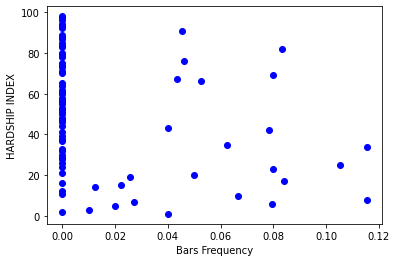

In [352]:
plt.scatter(color_yhat['Bar'], color_yhat['HARDSHIP INDEX'],  color='blue')
plt.xlabel('Bars Frequency')
plt.ylabel('HARDSHIP INDEX')

There appears to be a slight clustering of points up to 0.04 frequency, with lower hardship scores, less than 60. However, there is not a clear relationship. Most points lie around 0 (no bar venues in that community).

Now, let's create a scatter plot of the frequency of venues of type 'Storage Facility' v.s Harship

Text(0, 0.5, 'HARDSHIP INDEX')

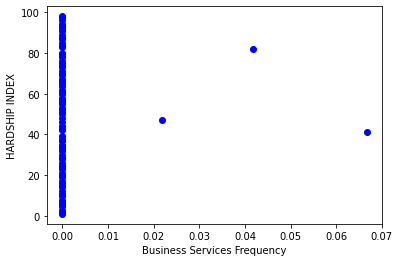

In [354]:
plt.scatter(color_yhat['Business Service'], color_yhat['HARDSHIP INDEX'],  color='blue')
plt.xlabel('Business Services Frequency')
plt.ylabel('HARDSHIP INDEX')

Here, there is definitely no clear relationship, and again, most of the x values are 0.

## Results

Chicago has a wide variety of venue types distributed across 77 community areas. Many of them are food related, including Mexican food, Thai food, African food, etc. <br><br>
However when we try to predict a neighborhood's hardship index using venues and assuming a mutli linear relationship, the results are not very accurate. Using the test data, the **variance score** was -0.67 and the **residual** error was 1395.55. When predicting values using the whole dataset, the scores were better, where variance was 0.55 and the residual error was 362.48. This indicates there would likely be a very low out of sample accuracy. Unfortunately there is not much data on hardship scores for neighborhoods across Chicago. Furthermore, the negative variance score on the test data indicates that the model obtained unexpected results, as the variance would normally be positive.<br><br>
As can be seen in the las two **folium maps** above, the predictions don't seem as bad on a map when we split the hardship values into categories (very low, low, high, very high) and predict the whole dataset. But again, it is likely the map would not look as accurate with out of sample data. <br><br>
We then used the values of the model's **coefficients** to determine which venue category seems to have the most effect on the hardship index. A large positive value would indicate this type of venue correlates with higher hardship scores, and a large negative value would be the opposite. As may be expected, many of the largest and smallest coefficients corresponded to food related venues. When plotting some of these more distinct categories vs hardship, there was no clear correlation, however. In addition, as can be seen in the scatter plots above, many of the venue category frequency values were 0, making it even harder to see any correlation. Strangely enough, the category "Bar" was the only venue type examined which seemed to somewhat show a relation. <br><br>
Finally, it is worth noting that the Chicago neighborhood with the highest hardship score of 98, also had 0 nearby venues found by the FourSquareAPI.

## Discussion

From the evaluation of our model, both through metrics and visual inspection, it can be determined that there is likely not any clear relationship between our venue categories and hardship score. It is most definitely not a mult linear relationship.<br><br>
When we predicted the hardship scores for the whole dataset using our model, the predicted results are somewhat close to the actual values. However, the predictions are much worse when we predict scores using our test dataset. Since low accuracy scores on test data indicate low out of sample accuracy, one may assume that a developer would not be able to accurately determine what type of new venues would most benefit a new or existing community.<br><br>
As mentioned above, it is worth noting that the neighborhood with the highest hardship score also had 0 venues found. This may just be a limitation of FourSquare, but still, it was the only neighborhood with no results. This single data point does not tell us much about the effect of venue categories however. Perhaps there is some relationship between the total number of venues and hardship, which could be looked into separately.<br><br> 
As for the coefficients of our model, there are some which are especially large, such as "Bar" and "Business Services". Normally, one would assume that this indicates that these variables have some relationship with the target. However, when plotted there is no clear relationship that can be observed. Perhaps with a larger dataset, with less 0 values, a more clear relationship can be observed. Still, it may be a good idea for city officials and developers to keep a watch on these venue categories or to conduct further studies on them. <br><br> 
After determining that the data does not have a multi linear relationship, one may ask if there is any sort of relationship between venue categories and the hardship score of Chicago neighborhoods. To determine this, one may refer back to the top venues for each neighborhood, all the category names, and the scatter plots for only 2 variables. For the top venues, there are mostly food venues, which doesn't tell us much. For category names, there are over 200 variables. It is generally more difficult to find a relationship with many independent variables. Finally, the scatter plots did not show any type of relationship that can be seen visually. So, with the currently available data, a clear relationship could not be established between the variables studied. With a much larger dataset, it may be easier to find a relationship. It may also help to better study the possible relationship between bars and hardship, as a very slight relationship may have been observed here. 

## Conclusion

The goal of this study was to explore how the types of venues in a given Chicago neighborhood may affect its hardship score. This would help city officials and land developers determine the types of venues which may be beneficial or detrimental to a community, and how large that effect may be. <br><br>
We began our study of this question by collecting data on the hardship scores of the 77 communities in Chicago. Then we also collected geolocation and venue data on each of the categories. After initial exploration of our dataset, we then began our model development. We chose to primarily explore a multi linear regression model because of our assumptions on the dynamics of a community. We also explored some of the venue categories individually to check for further predictions.<br><br>
There was definitely a wide variety of venue categories across the Chicago neighborhoods. A lot of them were food related. Interestingly enough, the community with the highest hardship index had 0 nearby venues found. This observation would be interesting to explore further using a larger dataset or different variables. From our MLR model itself, what we determined is that our data likely does not have a multi linear relationship, thus our model would not be the best to use to predict hardship scores or make recommendations on the type of new venue a community should have.<br><br> 
Perhaps one insight Chicago officials and developers may gain from this study is that there is a lot more factors that go into a community's economic wellbeing. Just changing the types of venues in a community may not have a significant impact on its economy. However one must keep in mind the scope of this study. Only the relationship between venue categories and hardship was studied and only on Chicago neighborhoods using Foursquare. It would be useful to conduct future studies where larger datasets were used or different variables were examined. 